In [1]:
%matplotlib inline
import os
import re
import shutil
from time import time
from datetime import datetime
from tqdm import tqdm
import math
import random
import collections
from mplfinance.original_flavor import candlestick2_ohlc
import warnings; warnings.filterwarnings("ignore")
from PIL import Image
from glob import glob

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from mplfinance.original_flavor import candlestick2_ohlc

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(415)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Add, Multiply, Dot, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model, get_custom_objects

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

## Set Gpu option

In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

## Load corp. info

In [6]:
kospi = pd.read_csv('data/kospi_info.csv', index_col=False)
kosdaq = pd.read_csv('data/kosdaq_info.csv', index_col=False)

In [14]:
len(kosdaq_code)

1455

In [7]:
kospi_code = list(kospi['code'])
kosdaq_code = list(kosdaq['code'])

kospi_name = list(kospi['name'])
kosdaq_name = list(kosdaq['name'])

## Hide plot outline, title, date ..

In [8]:
def draw_candle(data, code):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    index = data.index.astype('str')  # 캔들스틱 x축이 str로 들어감
    x = np.arange(len(data.index))
    candlestick2_ohlc(ax, data['open'], data['high'],
                      data['low'], data['close'],
                      width=0.6, colorup='tab:red', colordown='mediumblue')
    plt.tight_layout()
    ax.axis('off')
    fig.patch.set_visible(False)
    plt.savefig(f'./chart/candle/{code}.jpg', dpi=200)
    # plt.grid()
    # plt.show()
    plt.close()

In [9]:
def draw_volume(data, code):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    index = data.index.astype('str')  # 캔들스틱 x축이 str로 들어감
    x = np.arange(len(data.index))
    ax.bar(x, data.volume, color='k', width=0.6, align='center')
    ax.axis('off')
    plt.tight_layout()
    fig.patch.set_visible(False)
    plt.savefig(f'./chart/volume/{code}.jpg', dpi=200)
    # plt.grid()
    # plt.show()
    plt.close()

In [10]:
# sample_list = glob('./sample/*.csv')
# for sample in tqdm(sample_list):
#     code = re.findall('[A-Z0-9]+', sample)[0]
#     data = pd.read_csv(sample, index_col=False)
#     data.index = list(map(lambda x: datetime.strptime(str(x), '%Y%m%d').date(), data['date']))
#     data.drop(columns=['date'], inplace=True)
#     full_draw(data.iloc[-100:-1, :], code)
#     draw_candle(data.iloc[-100:-1, :], code)
#     draw_volume(data.iloc[-100:-1, :], code)

## Setup input data

- step 1 : original image contains "Candle" & "Volume" by (800x800)
- step 2 : Separate it into each images
- step 3 : Resize each image
- step 4 : Get target data from meta datasets

In [7]:
def get_image(code, path):
    
    def make_square(im, min_size=228):
        x, y = im.size
        size = min(min_size, x, y)
        new_im = im.resize((size, size))
        return new_im
        
    chart = Image.open(path + code + '.jpg')
    new_chart = make_square(chart)

    return np.array(new_chart)

In [8]:
def get_meta(code):
    
    meta_path = './sample/'
    meta_data = pd.read_csv(meta_path + code + '.csv', index_col=False)
    
    rate = np.array(meta_data['rate'])
    dir = np.array(meta_data['dir'])
    close = np.array(meta_data['close'])
    
    return rate, dir, close

## Get tensor-datasets

- step 1 : original image contains "Candle" & "Volume" by (800x800)
- step 2 : Separate it into each images
- step 3 : Resize each image
- step 4 : Get target data from meta datasets

In [13]:
def get_data(code_list):
    
    candle_data = []
    volume_data = []
    rate_output = []
    dir_output = []
    
    for code in tqdm(code_list):
        candle = get_image(code, './chart/candle/')
        volume = get_image(code, './chart/volume/')
        rate, dir, close = get_meta(code)
        
        candle_data.append(candle)
        volume_data.append(volume)
        rate_output.append(rate[-1])
        dir_output.append(dir[-1])

        
    candle_input = np.asarray(candle_data)
    volume_input = np.asarray(volume_data)
    rate_output = np.asarray(rate_output)
    dir_output = np.asarray(dir_output)
    
    return candle_input, volume_input, rate_output, dir_output

In [14]:
candle_input, volume_input, rate_output, dir_output = get_data(kospi_code+kosdaq_code)

100%|██████████| 2250/2250 [04:40<00:00,  8.02it/s]


## Check images

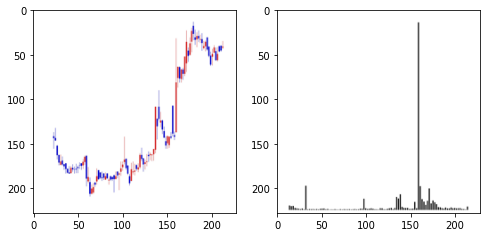

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
ax = plt.imshow(Image.fromarray(candle_input[0]))
ax = fig.add_subplot(1, 2, 2)
ax = plt.imshow(Image.fromarray(volume_input[0]))

In [16]:
print(f'candle_input shape : {candle_input.shape}')
print(f'volume_input shape : {volume_input.shape}')

print(f'rate_output shape : {rate_output.shape}')
print(f'dir_output shape : {dir_output.shape}')

candle_input shape : (2250, 228, 228, 3)
volume_input shape : (2250, 228, 228, 3)
rate_output shape : (2250,)
dir_output shape : (2250,)


## Custom tanh

- return rate : -0.3 ~ 0.3

In [18]:
def custom_tanh(x):
    return 0.6 / (1+K.exp(x*-0.5)) - 0.3

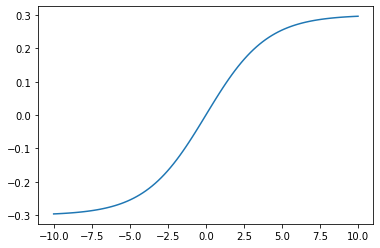

In [17]:
x = np.linspace(-10, 10, 100) 
z = 0.6/ (1+np.exp(x*-0.5)) - 0.3

plt.plot(x, z)

## Modeling

In [47]:
shutil.rmtree('../logs')

In [48]:
with tf.device('/gpu:0'):
    Input_candle = Input(shape=(228, 228, 3))
    Input_volume = Input(shape=(228, 228, 3))

    c_conv_1 = Conv2D(32, (2, 2), activation='relu', padding='same', name='Candle_input')(Input_candle)
    c_pool_1 = MaxPooling2D((2, 2))(c_conv_1)
    c_conv_2 = Conv2D(16, (2, 2), activation='relu', padding='same')(c_pool_1)
    c_pool_2 = GlobalMaxPooling2D()(c_conv_2)

    v_conv_1 = Conv2D(32, (2, 2), activation='relu', padding='same', name='Volume_input')(Input_volume)
    v_pool_1 = MaxPooling2D((2, 2))(v_conv_1)
    v_conv_2 = Conv2D(16, (2, 2), activation='relu', padding='same')(v_pool_1)
    v_pool_2 = GlobalMaxPooling2D()(v_conv_2)

    concat = Concatenate()([c_pool_2, v_pool_2])
    fc_1 = Dense(32, activation='relu')(concat)
    fc_2 = Dense(16, activation='relu')(fc_1)
    fc_3 = Dense(8, activation='relu')(fc_2)
    fc_2 = Dropout(0.5)(fc_2)
    out = Dense(1, activation='sigmoid')(fc_3)

    base_model = Model(inputs=[Input_candle, Input_volume], outputs=out)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/repl

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 228, 228, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 228, 228, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 228, 228, 32) 416         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 228, 228, 32) 416         input_14[0][0]                   
____________________________________________________________________________________________

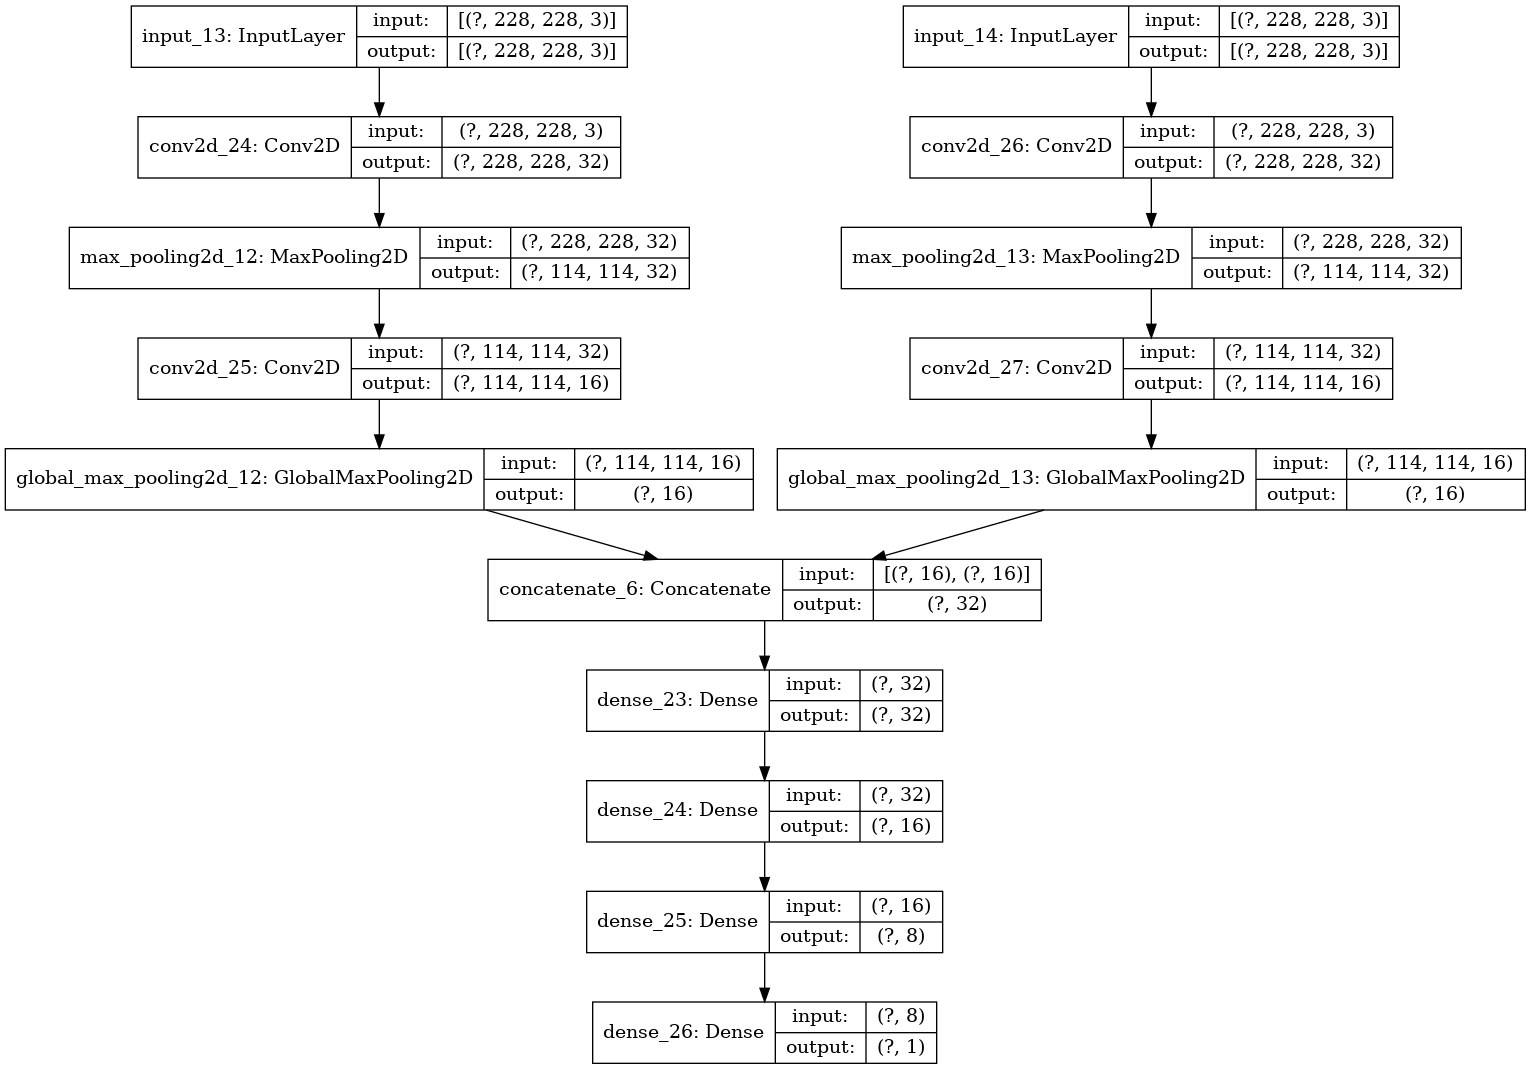

In [49]:
base_model.summary()
plot_model(base_model, show_shapes=True)

In [55]:
init_epochs = 100
init_lr = 0.001

In [52]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

history = base_model.fit(
    [candle_input, volume_input],
    dir_output,
    batch_size=16,
    epochs=init_epochs,
    callbacks=[TensorBoard(log_dir="../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "base_model")
               ModelCheckpoint(
                   filepath = './checkpoint', save_weights_only = True, 
                   monitor = 'var_accuracy', 
                   mode = 'max',
                   save_best_only = True), 
               EarlyStopping(monitor = 'loss', patience = 3)]
    validation_split=0.2)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6519 - accuracy: 0.6278 - val_loss: 0.6467 - val_accuracy: 0.6089
Epoch 10/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6580 - accuracy: 0.6000 - val_loss: 0.6320 - val_accuracy: 0.6467
Epoch 11/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6589 - accuracy: 0.6111 - val_loss: 0.6424 - val_accuracy: 0.6467
Epoch 12/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6488 - accuracy: 0.6311 - val_loss: 0.6338 - val_accuracy: 0.6467
Epoch 13/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6421 - accuracy: 0.6217 - val_loss: 0.6499 - val_accuracy: 0.6467
Epoch 14/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6420 - accuracy: 0.6350 - val_loss: 0.6290 - val_accuracy: 0.6444
Epoch 15/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6478 - accuracy: 0.6283 - val_loss: 0.6309 

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6160 - accuracy: 0.6544 - val_loss: 0.6773 - val_accuracy: 0.6467
Epoch 51/100
1800/1800 [==============================] - 4s 2ms/sample - loss: 0.6274 - accuracy: 0.6489 - val_loss: 0.6607 - val_accuracy: 0.5622
Epoch 52/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6170 - accuracy: 0.6561 - val_loss: 0.6546 - val_accuracy: 0.5867
Epoch 53/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6117 - accuracy: 0.6606 - val_loss: 0.6304 - val_accuracy: 0.6467
Epoch 54/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6011 - accuracy: 0.6711 - val_loss: 0.6739 - val_accuracy: 0.5578
Epoch 55/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6078 - accuracy: 0.6650 - val_loss: 0.6765 - val_accuracy: 0.6467
Epoch 56/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.6149 - accuracy: 0.6483 - val_loss: 0.6377 

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5512 - accuracy: 0.7089 - val_loss: 0.6786 - val_accuracy: 0.6222
Epoch 92/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5458 - accuracy: 0.7156 - val_loss: 0.6557 - val_accuracy: 0.6333
Epoch 93/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5618 - accuracy: 0.7056 - val_loss: 0.6519 - val_accuracy: 0.6333
Epoch 94/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5467 - accuracy: 0.7183 - val_loss: 0.6728 - val_accuracy: 0.6378
Epoch 95/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5459 - accuracy: 0.7200 - val_loss: 0.6663 - val_accuracy: 0.6622
Epoch 96/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5409 - accuracy: 0.7267 - val_loss: 0.6969 - val_accuracy: 0.6533
Epoch 97/100
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.5306 - accuracy: 0.7383 - val_loss: 0.6924 

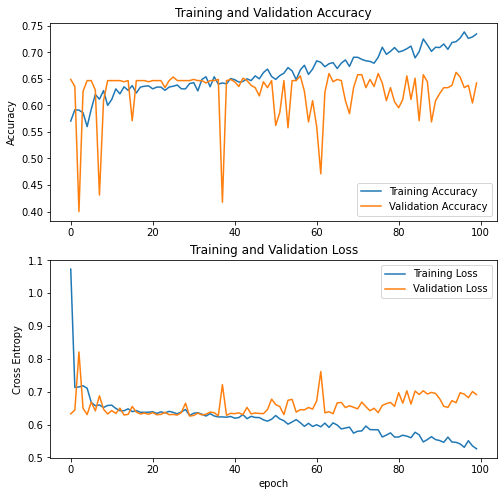

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
total_epochs

200

In [60]:
fine_tune_epochs = 100
total_epochs =  init_epochs + fine_tune_epochs

In [61]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = init_lr/10),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

history_fine = base_model.fit([candle_input, volume_input],
                              dir_output,
                              callbacks=[tb, mc, es],
                              batch_size=16,
                              epochs=total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_split=0.2)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4607 - accuracy: 0.7783 - val_loss: 0.7738 - val_accuracy: 0.6156
Epoch 109/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4624 - accuracy: 0.7822 - val_loss: 0.7645 - val_accuracy: 0.6244
Epoch 110/200
1800/1800 [==============================] - 4s 2ms/sample - loss: 0.4585 - accuracy: 0.7800 - val_loss: 0.7715 - val_accuracy: 0.6333
Epoch 111/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4627 - accuracy: 0.7800 - val_loss: 0.7734 - val_accuracy: 0.6200
Epoch 112/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4564 - accuracy: 0.7861 - val_loss: 0.8020 - val_accuracy: 0.6067
Epoch 113/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4563 - accuracy: 0.7828 - val_loss: 0.7876 - val_accuracy: 0.6200
Epoch 114/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4553 - accuracy: 0.7783 - val_loss: 0

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4178 - accuracy: 0.7994 - val_loss: 0.8850 - val_accuracy: 0.6267
Epoch 150/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4188 - accuracy: 0.8006 - val_loss: 0.8559 - val_accuracy: 0.6111
Epoch 151/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4172 - accuracy: 0.8000 - val_loss: 0.8755 - val_accuracy: 0.6067
Epoch 152/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4147 - accuracy: 0.8044 - val_loss: 0.8820 - val_accuracy: 0.6289
Epoch 153/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4113 - accuracy: 0.8072 - val_loss: 0.8688 - val_accuracy: 0.6089
Epoch 154/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4173 - accuracy: 0.7983 - val_loss: 0.8519 - val_accuracy: 0.6200
Epoch 155/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.4134 - accuracy: 0.8061 - val_loss: 0

1800/1800 [==============================] - 3s 2ms/sample - loss: 0.3843 - accuracy: 0.8072 - val_loss: 0.9794 - val_accuracy: 0.6200
Epoch 191/200
1800/1800 [==============================] - 4s 2ms/sample - loss: 0.3971 - accuracy: 0.8083 - val_loss: 0.9426 - val_accuracy: 0.6156
Epoch 192/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.3835 - accuracy: 0.8094 - val_loss: 0.9442 - val_accuracy: 0.6156
Epoch 193/200
1800/1800 [==============================] - 4s 2ms/sample - loss: 0.3822 - accuracy: 0.8100 - val_loss: 0.9585 - val_accuracy: 0.6178
Epoch 194/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.3800 - accuracy: 0.8144 - val_loss: 0.9594 - val_accuracy: 0.6156
Epoch 195/200
1800/1800 [==============================] - 4s 2ms/sample - loss: 0.3820 - accuracy: 0.8189 - val_loss: 0.9820 - val_accuracy: 0.6178
Epoch 196/200
1800/1800 [==============================] - 3s 2ms/sample - loss: 0.3800 - accuracy: 0.8150 - val_loss: 0

In [64]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

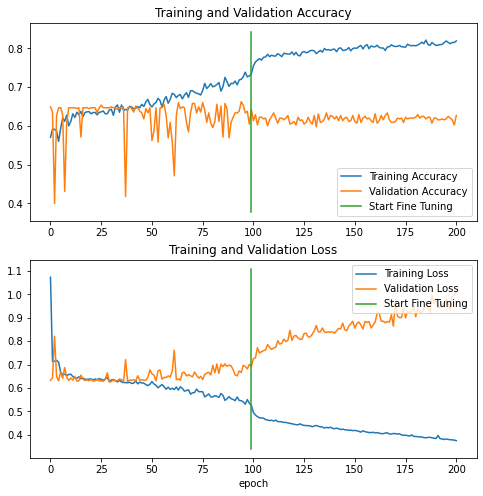

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 2nd base_model

In [ ]:
##### with tf.device('/gpu:0'):
    Input_candle = Input(shape=(228, 228, 3))
    Input_volume = Input(shape=(228, 228, 3))

    c_conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Candle_input')(Input_candle)
    c_pool_1 = MaxPooling2D((3, 3))(c_conv_1)
    c_conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c_pool_1)
    c_pool_2 = MaxPooling2D((3, 3))(c_conv_2)
    c_conv_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(c_pool_2)
    c_pool_3 = GlobalMaxPooling2D()(c_conv_3)

    v_conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Volume_input')(Input_volume)
    v_pool_1 = MaxPooling2D((3, 3))(v_conv_1)
    v_conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(v_pool_1)
    v_pool_2 = MaxPooling2D((3, 3))(v_conv_2)
    v_pool_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(v_pool_2)
    v_pool_3 = GlobalMaxPooling2D()(v_pool_3)
                                  
    concat = Concatenate()([c_pool_3, v_pool_3])
    fc_1 = Dense(32, activation='relu')(concat)
    fc_2 = Dense(16, activation='relu')(fc_1)
    fc_3 = Dense(8, activation='relu')(fc_2)
    fc_2 = Dropout(0.5)(fc_2)
    out = Dense(1, activation='sigmoid')(fc_3)

    base_model2 = Model(inputs=[Input_candle, Input_volume], outputs=out)

In [ ]:
base_model2.summary()
plot_model(base_model2, show_shapes=True)

In [91]:
init_epochs = 100
init_lr = 0.001

In [ ]:
base_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history = base_model2.fit(
    [candle_input, volume_input],
    dir_output,
    batch_size=16,
    epochs=init_epochs,
    callbacks=[TensorBoard(log_dir="../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "base_model")
               ModelCheckpoint(
                   filepath = './checkpoint', save_weights_only = True, 
                   monitor = 'var_accuracy', 
                   mode = 'max',
                   save_best_only = True), 
               EarlyStopping(monitor = 'loss', patience = 3)]
    validation_split=0.2)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet